In [1]:
# Homework 3 (due 07/16/2024)

# Eigenbears

## Instructions

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears. 
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images. 

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears. 
2. What method gives you the best test accuracy? 
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

--------------------------------

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time

## Part 1: Data preparation

In [3]:
# toggle settings
add_noise = False

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = '/Users/ckelv/Downloads/PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = '/Users/ckelv/Downloads/PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

/Users/ckelv/Downloads/PandasBears/Train/Pandas/ has 250 images
/Users/ckelv/Downloads/PandasBears/Train/Bears/ has 250 images
/Users/ckelv/Downloads/PandasBears/Test/Pandas/ has 50 images
/Users/ckelv/Downloads/PandasBears/Test/Bears/ has 50 images


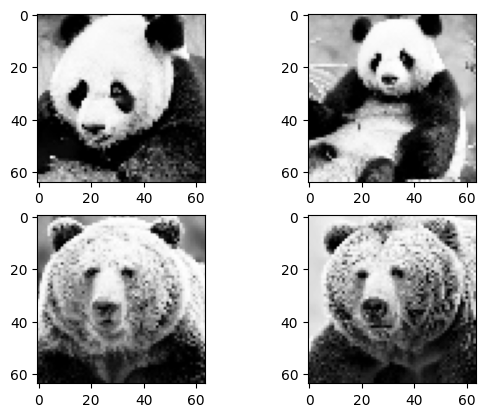

In [4]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

# Part 2: Singular value decomposition

In [5]:
# Construct data matrix of centered data
'''ADD SOME CODE HERE'''
train_images = np.array(train_images)
test_images = np.array(test_images)
flattened_images = train_images.reshape(500, 128*128)
avgBear = np.mean(train_images,axis=0).flatten()

X = flattened_images - np.tile(avgBear[np.newaxis,:], (500,1))
X = X.T

# Perform SVD
U, S, Vh = np.linalg.svd(X, full_matrices = False) # replace A with your centered data matrix

In [6]:
#average bear
# plt.imshow(avgBear.reshape(128,128), cmap = "Greys_r")

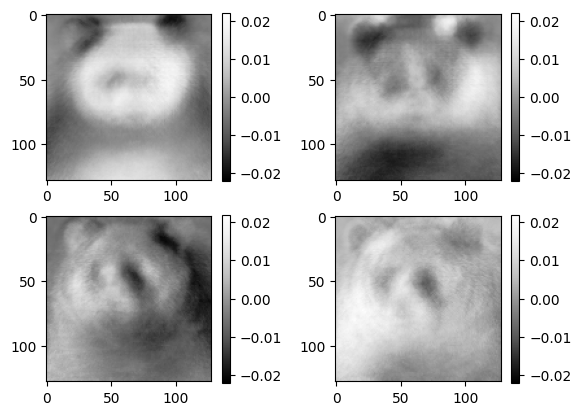

In [7]:
# show the first four eigenbears
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow((U[:,i]).reshape((128,128)), cmap='Greys_r',
        # force colormap to be the same for all four
        vmin=-np.max(np.abs(U[:,:4])),
        vmax=np.max(np.abs(U[:,:4])))
    plt.colorbar()
plt.subplots_adjust(wspace=0.4)

In the first 4 eigenbears, we can see the top 2 look vaguely like a panda bear and the bottom 2 look vaguely like grizzly bears. The eigenbears are what the model considers as the most fundamental features of all of the data. It makes sense that the pictured eigenbears are like the decompositions of the pandas and grizzlies as these are the most fundamental features that are used to distinguish between pandas and grizzlies.

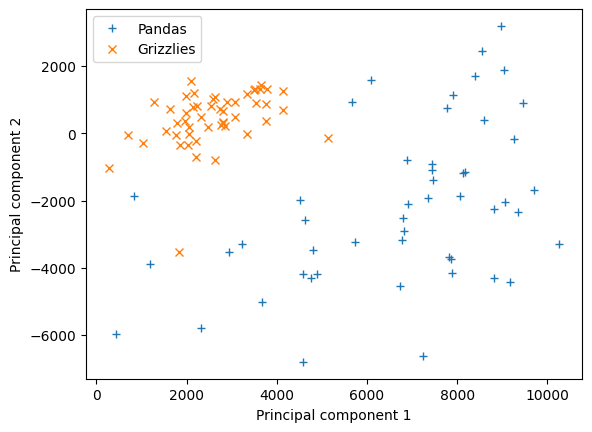

In [8]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images[x])) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x])) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()

It seems using PCA, the grizzlies are clustered in the top left while the pandas are more scattered around. This might suggest that there is more variability in the images of pandas than there are grizzlies. Or at least that the grizzlies are more easily decomposed into 2 components than the pandas.

# Part 3: Nonparametric classification

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
flattened_train = train_images.reshape(500, 128*128)
flattened_test = test_images.reshape(100, 128*128)
x_train = np.concatenate([(flattened_train[0:250]), (flattened_train[250:500])])
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the 
# list of test images. We code pandas as '0' and brown bears as '1'.
x_test = np.concatenate([(flattened_test[0:50]), (flattened_test[50:100])])
y_test = np.concatenate([np.zeros(50), np.ones(50)])

    
removeIndex = False
if(removeIndex == True):
    x_true_train = []
    x_true_test = []
    for i in range(len(x_train)):
        x_true_train.append(x_train[i])

    for i in range(len(x_test)):
        x_true_test.append(x_test[i])
    x_train = x_true_train
    x_test = x_true_test

In [11]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')
errors = []
for k in range(1,16):
    # fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
    # use model to make predictions on the test set
    predictionsKN = modelKN.predict(x_test)
    # detect misclassifications
    errorsKN = np.abs(predictionsKN-y_test)
    # print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errorsKN)), (np.argwhere(errorsKN).T)[0]))
    errors.append(int(np.sum(errorsKN)))
print(np.mean(errors))

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      1 	| [39]
    2	|      0 	| []
    3	|      2 	| [39 42]
    4	|      1 	| [42]
    5	|      3 	| [36 39 42]
    6	|      2 	| [36 42]
    7	|      4 	| [22 36 41 42]
    8	|      2 	| [22 42]
    9	|      4 	| [ 6 22 36 42]
    10	|      3 	| [ 6 22 42]
    11	|      4 	| [ 6 22 41 42]
    12	|      4 	| [ 6 22 41 42]
    13	|      5 	| [ 6 22 39 41 42]
    14	|      5 	| [ 6 22 39 41 42]
    15	|      7 	| [ 6 11 22 24 39 41 42]
3.1333333333333333


We can see when k = 2, meaning we evaluate our decision based on the 2 nearest bears, we get no misclassified bears.

One interesting observation is that all of the misclassified bears are pandas misclassified as grizzlies.
There were no grizzlies misclassfied as pandas.

This corresponds to the 2D PCA projection where the grizzlies were all tightly clustered whereas the pandas were spread out.

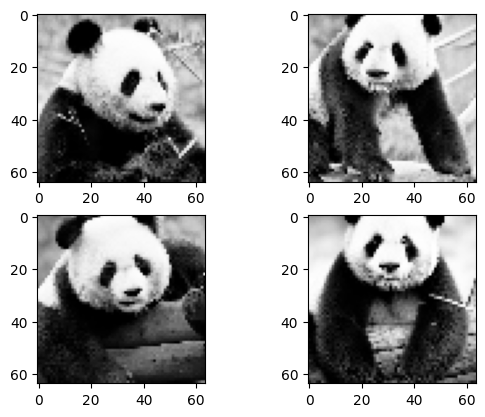

In [12]:
# Show hard-to-classify bears
'''ADD SOME CODE'''
# bears 6, 22, 39, 42 were misclassified most often
# look at 4 most misclassified bears
for i0, i in enumerate([6, 22, 39, 42]):
    plt.subplot(2,2,1+i0)
    plt.imshow(test_images[i][::2,::2],cmap='Greys_r')

It's possible these test pandas have grizzlies in the training set that are in similar poses as the pandas. This means that the nearest neighbor for the panda will be a grizzly which results in misclassification.

Referring back to the 2D PCA projection, although it isn't a 1 to 1 comparison since the dimensionality of the PCA is smaller than the KNN model, there are several pandas that are closer to the grizzly cluster than they are to the pandas. This could be reflected by the KNN model as the panda points closest to the grizzlies will end up being misclassified as grizzlies.

# Part 4: Parametric classification

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [14]:
lg = LogisticRegression()
modelLG = lg.fit(x_train, y_train)
# use model to make predictions on the test set
predictionsLG = modelLG.predict(x_test)
# detect misclassifications
errorsLG = np.abs(predictionsLG-y_test)
# print results to table
print('#errors: {} \t | misclassified bears: {}'.format(int(np.sum(errorsLG)), (np.argwhere(errorsLG).T)[0]))

#errors: 0 	 | misclassified bears: []


In [15]:
'''ADD SOME CODE'''
lda = LinearDiscriminantAnalysis(store_covariance=True)
modelLDA = lda.fit(x_train, y_train)
# use model to make predictions on the test set
predictionsLDA = modelLDA.predict(x_test)
# detect misclassifications
errorsLDA = np.abs(predictionsLDA-y_test)
# print results to table
print('#errors: {} \t | misclassified bears: {}'.format(int(np.sum(errorsLDA)), (np.argwhere(errorsLDA).T)[0]))

#errors: 1 	 | misclassified bears: [72]


Logistic regression had perfect test accuracy while LDA misclassified 1 grizzly as a panda.

The parametric models performed significantly better than the non-parametric ones.

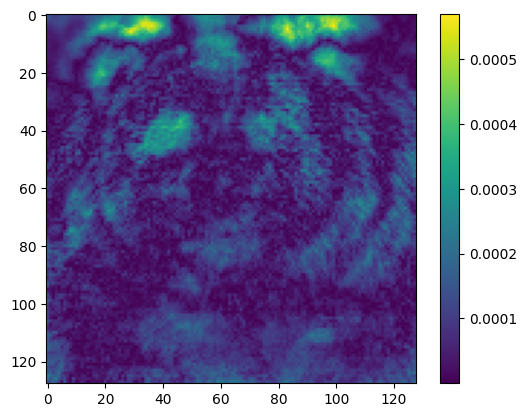

In [16]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((modelLG.coef_).reshape((128,128))))
plt.colorbar()

We can see some key features that are useful to distinguish the bears. We can see the most important features that are highlighted in green and yellow where the ears and eyes tend to appear for pandas. This means that the logistic regression model uses the pixels in the ear and eye positions to distinguish whether the bear is a panda or a grizzly. It also means that pandas and grizzlies tend to have different colors in those pixels.

# Adding noise

After adding noise, the KNN went from 1, 0, 2, 1, 3, 2, 4, 2, 4, 3, 4, 4, 5, 5, and 7 misclassified bears depending on the number of evaluated neighbors to 2, 0, 2, 1, 3, 2, 3, 3, 3, 2, 6, 3, 5, 5, and 7 misclassified bears. This was no change from an average of 3.133 misclassified bears to 3.133 misclassified bears. Also, in both cases, KNN with k = 2 still had perfect accuracy.

(Note: After running the models several times to account for the randomness of the noise generation, the KNN did have slightly varying results, but the final average number of misclassified bears was always higher than the no noise KNN model.)

(The highest error obtained through testing was an average of 4.2 misclassified bears which is still close to the no noise 3.133)

The logistic regression went from no misclassified bears to 1 error which was panda 42.

The LDA went from 1 error which was grizzly 72 to 1 error which was panda 42.

I would expect the noise to increase the number of misclassified bears, but it barely had an impact on the models. I suppose this is because for the parametric models, the weights on the most useful pixels are strong enough to not be influenced by the added noise. And for the non-parametric KNN model, since all pixels had the same error distribution, the average difference would cancel to 0.

The eigenbears are very slightly fuzzier with noise, but the base bears are the exact same. It should be noted that the eigenbears actually removed a lot of the noise of the data set.

On the bear mask, all of the pixels have lower confidence and are darker, this makes it so the silhouette of the bear is not visible. However, the ears and eyes are still very visible and stand out.

All of the images were AI generated the pandas and grizzlies have very similar poses and look somewhat alike. But in practice, there will be different poses and facial structures. There may also be different noise distractions like background objects. Having nonuniform noise distributions applied to the images would mean that models like KNN would be affected more heavily and more likely to misclassify.